In [1]:
# Hai Duong Nguyen z5521050

# Step 1: Set up environment

Based on what we know about Taxi-v3, which includes:


*   Total of states: 500 (25 positions of taxi (5x5 grid) x 5 positions of passenger x 4 destination locations = 500 states)
*   Number of actions: 6 (up, down, left, right, pick up, drop off)
*   Reward: +20 for sucessful drop-off, -1 for each step, -10 for illegal pick-up/drop-off

The Q-table is a matrix that stores the estimated Q-values for each state-action pair. So, we initialize Q-table using total of states and number of actions.

Each entry Q[state][action] in the Q-table will represent the agent's estimate of the total future reward it will receive.





In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Initialize environment
env = gym.make('Taxi-v3', render_mode="ansi").env

# Get number of states and actions
num_states = env.observation_space.n
num_actions = env.action_space.n

# Initialize Q-tables for Q-learning and SARSA
Q_qlearning = np.zeros((num_states, num_actions))
Q_sarsa = np.zeros((num_states, num_actions))

# Step 2: Training
We specify number of episodes, here I choose 2000 since the minimum requirement is 1000. I find 2000 is the most optimal number, higher might result in overfitting.

In [3]:
num_episodes = 2000

I decied to use Softmax method to achieve balance in reinforcement learning. The softmax equation is:

\begin{equation}
\text{softmax}(Q_t(a)) = \frac{e^{Q_t(a) / T}}{\sum_{i=1} e^{Q_t(i) / T}}
\end{equation}

Where:
- $Q_t (a)$ are the Q-values for each action.
- T is the temperature parameter.

In [4]:
def softmax(x, temperature):
    # Compute softmax values for each sets of scores in x
    e_x = np.exp(x / temperature)
    return e_x / np.sum(e_x)

## 2.1. Q-learning
Q-learning is an off-policy algorithm that updates Q-values based on the maximum possible reward in the next state.

Here I specify the hyperparameters:

* Learning Rate (alpha_q): alpha_q = 0.75 determines the rate at which the algorithm updates the Q-values.
* Discount Factor (gamma_q): gamma_q = 0.85 determines the importance of future rewards. A value closer to 1 means future rewards are considered more important.
* Temperature (T_q): T_q = 0.7 is used in the softmax function to control the exploration-exploitation trade-off, here I choose 0.7 so it will likely to choose the action with the highest Q-value, but still have a moderate exploration


In [5]:
# Hyperparameters for Q-learning
alpha_q = 0.75 # Learning rate
gamma_q = 0.85 # Discount factor
T_q = 0.7 # Temperature for softmax

In the Q-learning method, state-action values are updated using the best possible action from the next state.

\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t)+\alpha[r_{t+1}+\gamma\max_{a \in A(s_{t+1})} Q(s_{t+1},a)- Q(s_t,a_t)]
\end{equation}

Where:
- $Q(s_t, a_t)$ is the Q-value for the current state $s_t$ and the current action $a_t$. It represents the agent's current estimate of the total future reward it will receive after taking action $a_t$ in state $s_t$.
- $\alpha$ (alpha) is the learning rate, which determines how much new information overrides the old information. It ranges between 0 and 1. A higher value means the agent is more influenced by new information.
- $r_{t+1}$ is the reward received after taking action $a_t$ and transitioning to the new state $s_{t+1}$.
- $\gamma$ (gamma) is the discount factor, which determines the importance of future rewards. It also ranges between 0 and 1. A higher value means future rewards are considered more important.
- $\max_{a \in A(s_{t+1})} Q(s_{t+1}, a)$ is the maximum Q-value for the next state $s_{t+1}$ over all possible actions $a$. This represents the best possible future reward from state $s_{t+1}$.
- $Q(s_t, a_t)$ on the right side of the equation is the current Q-value for the state $s_t$ and action $a_t$, which gets updated by adding the learning term.

This equation updates the Q-value for the state-action pair $(s_t, a_t)$ by a combination of:
- The old Q-value.
- A term that includes the reward received and the discounted estimate of the optimal future reward, scaled by the learning rate.

In [6]:
rewards_q = [] # Store rewards for Q-learning
steps_q = [] # Store steps for Q-learning

# Q-learning
for episode in range(num_episodes):
    # Reset environment to starting state
    state = env.reset()[0]
    total_reward = 0
    total_steps = 0

    while True:
        # Choose an action using the softmax policy based on the current state's Q-values
        action_probabilities = softmax(Q_qlearning[state, :], T_q)
        action = np.random.choice(num_actions, p=action_probabilities)

        # Take the chosen action, observe the new state and reward, and check if the episode is done
        new_state, reward, done, _, info = env.step(action)

        # Update Q-values using the equation
        Q_qlearning[state, action] = Q_qlearning[state, action] + alpha_q * (reward + gamma_q * np.max(Q_qlearning[new_state, :]) - Q_qlearning[state, action])

        # Update the current state to the new state
        state = new_state

        # Accumulate the total reward for the episode
        total_reward += reward

        # Increment the total number of steps taken in the episode
        total_steps += 1

        if done:
            break

    # Store the total reward and total number of steps taken in the episode
    rewards_q.append(total_reward)
    steps_q.append(total_steps)

C:\Users\Nguyen Hai Duong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## 2.2. SARSA
The on-policy method SARSA considers transitions from state-action pair to state-action pair.

Here I specify the hyperparameters:

* Learning Rate (alpha_s): alpha_s = 0.7 means that 70% of the new information will be used to update the old Q-value.
* Discount Factor (gamma_s): gamma_s = 0.95 means that future rewards are almost as important as immediate rewards.
* Temperature (T_s): T_s = 0.5 meaning while the agent will often choose the best-known action, it will still occasionally try other actions to discover potentially better strategies


In [7]:
# Hyperparameters for SARSA
alpha_s = 0.7 # Learning rate
gamma_s = 0.95 # Discount factor
T_s = 0.5 # Temperature for softmax

The SARSA update rule is defined based on the softmax policy. The actions are selected based on a probability distribution that is influenced by the Q-values and the temperature parameter. Higher Q-values lead to higher probabilities, but all actions have some chance of being selected.


\begin{equation}
Q(s_t,a_t) \leftarrow Q(s_t,a_t)+\alpha[r_{t+1}+\gamma Q(s_{t+1},a_{t+1})- Q(s_t,a_t)]
\end{equation}

Where:
- $Q(s_t, a_t)$ is the Q-value for the current state $s_t$ and the current action $a_t$. It represents the agent's current estimate of the total future reward it will receive after taking action $a_t$ in state $s_t$.
- $\alpha$ (alpha) is the learning rate, which determines how much new information overrides the old information. It ranges between 0 and 1. A higher value means the agent is more influenced by new information.
- $r_{t+1}$ is the reward received after taking action $a_t$ and transitioning to the new state $s_{t+1}$.
- $\gamma$ (gamma) is the discount factor, which determines the importance of future rewards. It also ranges between 0 and 1. A higher value means future rewards are considered more important.
- $Q(s_{t+1}, a_{t+1})$ is the Q-value for the next state $s_{t+1}$ and the next action $a_{t+1}$. This represents the estimated reward of the next state-action pair following the current policy.
- $Q(s_t, a_t)$ on the right side of the equation is the current Q-value for the state $s_t$ and action $a_t$, which gets updated by adding the learning term.

This equation updates the Q-value for the state-action pair $(s_t, a_t)$ by a combination of:
- The old Q-value.
- A term that includes the reward received and the discounted estimate of the future reward for the next state-action pair, scaled by the learning rate.

In [8]:
rewards_s = [] # Store rewards for SARSA
steps_s = [] # Store steps for SARSA

# SARSA
for episode in range(num_episodes):
    # Reset environment to starting state
    state = env.reset()[0]

    total_reward = 0
    total_steps = 0

    # Choose an action using the softmax policy based on the current state's Q-values
    action_probabilities = softmax(Q_sarsa[state, :], T_s)
    action = np.random.choice(num_actions, p=action_probabilities)

    while True:
        # Take the chosen action, observe the new state and reward, and check if the episode is done
        new_state, reward, done, _, info = env.step(action)

        # Choose a new action using the softmax policy based on the new state's Q-values
        new_action_probabilities = softmax(Q_sarsa[new_state, :], T_s)
        new_action = np.random.choice(num_actions, p=new_action_probabilities)

        # Update Q-values using the equation
        Q_sarsa[state, action] = Q_sarsa[state, action] + alpha_s * (reward + gamma_s * Q_sarsa[new_state, new_action] - Q_sarsa[state, action])

        # Update the current state and action to the new state and action
        state, action = new_state, new_action

        # Accumulate the total reward for the episode
        total_reward += reward
        # Increment the total number of steps taken in the episode
        total_steps += 1
        
        if done:
            break

    # Store the total reward and total number of steps taken in the episode
    rewards_s.append(total_reward)
    steps_s.append(total_steps)

# Step 3: Accumulated rewards and steps per episode plots

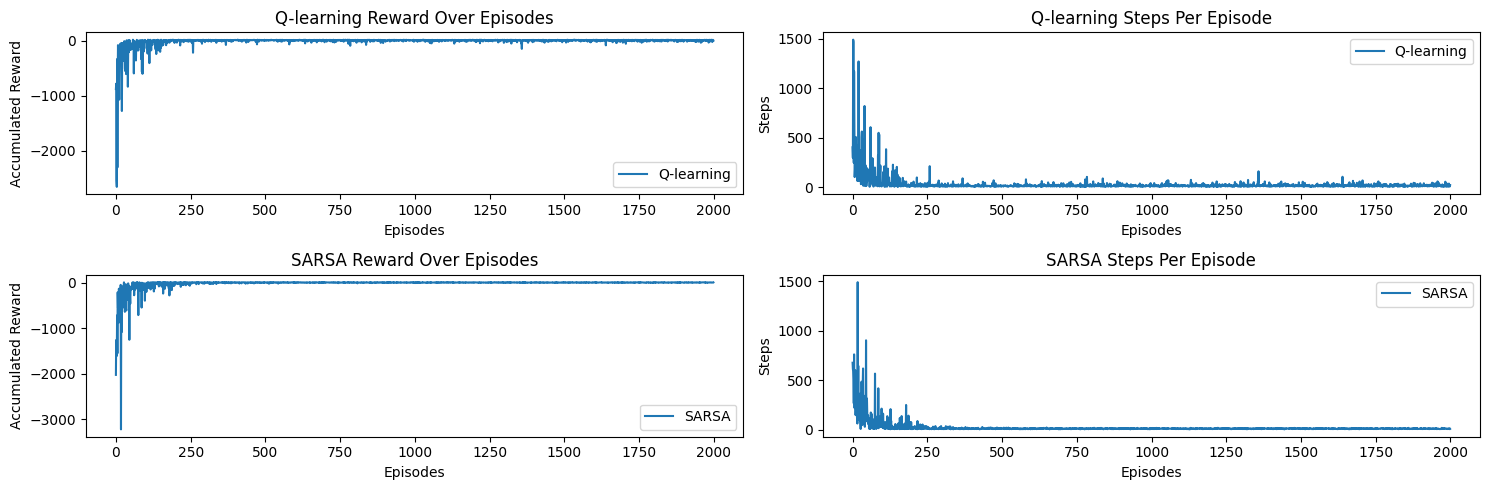

In [9]:
# Plotting the results
episodes = range(num_episodes)

plt.figure(figsize=(15, 5))

# Plot rewards and steps for Q-learning
plt.subplot(2, 2, 1)
plt.plot(episodes, rewards_q, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')
plt.title('Q-learning Reward Over Episodes')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(episodes, steps_q, label='Q-learning')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('Q-learning Steps Per Episode')
plt.legend()

# Plot rewards and steps for SARSA
plt.subplot(2, 2, 3)
plt.plot(episodes, rewards_s, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Accumulated Reward')
plt.title('SARSA Reward Over Episodes')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(episodes, steps_s, label='SARSA')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.title('SARSA Steps Per Episode')
plt.legend()

plt.tight_layout()
plt.show()

Save the Q-table for both Q-learning and SARSA:

In [10]:
# # Save Q-learning Q-table
# np.save("Q_qlearning.npy", Q_qlearning)
# # Save SARSA Q-table
# np.save("Q_sarsa.npy", Q_sarsa)

# Step 4: Evaluation

Here we load the Q-tables, and specify the number of test episodes, in this case is 100.

In [11]:
# Load Q-tables for testing
Q_qlearning_test = np.load("Q_qlearning.npy")
Q_sarsa_test = np.load("Q_sarsa.npy")

num_test_episodes = 100

For testing, we use greedy action medthod. This method is the simplest way to choose an action: the action with the highest estimated value.

In [12]:
def greedy_action(Q, state):
    # Choose the action with the highest Q-value for the given state
    return np.argmax(Q[state, :])

I evaluate the performance of agents trained using Q-learning and SARSA algorithms in the Taxi-v3 environment by calculating the average rewards and steps taken over a specified number of test episodes, and checks if the performance meets requirements of the assignment.

- For Qlearning algorithm, we aim for the agent to perform at most 14 steps per episode on average and obtain a minimum of 7 average accumulated reward.

- For SARSA algorithm, we aim for the agent to perform at most 15 steps per
episode on average and obtain a minimum of 5 average accumulated reward.



In [13]:
# Evaluation for Q-learning
total_reward_qlearning = 0
total_steps_qlearning = 0

for episode in range(num_test_episodes):
    state = env.reset()[0]
    steps = 0
    while True:
        # Choose the greedy action based on the Q-values
        action = greedy_action(Q_qlearning_test, state)

        # Take the chosen action, observe the new state and reward, and check if the episode is done
        state, reward, done, _, info = env.step(action)

        # Accumulate the total reward for the episode
        total_reward_qlearning += reward
        steps += 1
        if done:
            break
    total_steps_qlearning += steps

# Evaluation for SARSA
total_reward_sarsa = 0
total_steps_sarsa = 0

for episode in range(num_test_episodes):
    state = env.reset()[0]
    steps = 0
    while True:
        # Choose the greedy action based on the Q-values
        action = greedy_action(Q_sarsa_test, state)

        # Take the chosen action, observe the new state and reward, and check if the episode is done
        state, reward, done, _, info = env.step(action)

        # Accumulate the total reward for the episode
        total_reward_sarsa += reward
        steps += 1
        if done:
            break
    total_steps_sarsa += steps

# Calculate average reward and steps for Q-learning and SARSA
avg_reward_q = total_reward_qlearning / num_test_episodes
avg_steps_q = total_steps_qlearning / num_test_episodes

avg_reward_s = total_reward_sarsa / num_test_episodes
avg_steps_s = total_steps_sarsa / num_test_episodes

# Check requirements
qlearning_requirements_met = avg_steps_q <= 14 and avg_reward_q >= 7
sarsa_requirements_met = avg_steps_s <= 15 and avg_reward_s >= 5

print(f"Q-learning:\nAvg Reward: {avg_reward_q}, Avg Steps: {avg_steps_q}")
print(f"Requirements Met: {qlearning_requirements_met}\n")
print(f"SARSA:\nAvg Reward: {avg_reward_s}, Avg Steps: {avg_steps_s}")
print(f"Requirements Met: {sarsa_requirements_met}")

Q-learning:
Avg Reward: 7.58, Avg Steps: 13.42
Requirements Met: True

SARSA:
Avg Reward: 6.54, Avg Steps: 14.46
Requirements Met: True


# Step 5: Visualization

Final step is to visualize the performance of trained agents for both Q-learning and SARSA algorithms in the Taxi-v3 environment (ansi mode). The visualization shows the steps taken by the agent and the rewards accumulated during an episode.

Here we choose the maximum step of 100 so the visualization runs for a maximum of 100 steps or until the episode is done.

In [14]:
max_steps = 100

# Visualize the agent for Q-learning
def visualize_qlearning():
    # Reset environment to starting state
    state = env.reset()[0]

    done = False
    steps = 0
    total_reward = 0
    
    print("\nQ-learning Visualization\n")
    while not done and steps < max_steps:
        # Choose the greedy action based on the Q-values
        action = greedy_action(Q_sarsa_test, state)

        # Take the chosen action, observe the new state and reward, and check if the episode is done
        new_state, reward, done, _, _ = env.step(action)

        # Accumulate the total reward for the episode
        total_reward += reward

        # Print the current state, action, reward, and total accumulated reward
        print(env.render())
        print(f"Step: {steps}, State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {total_reward}")
        
        # Update the current state to the new state
        state = new_state
        steps += 1

    # Print the total number of steps taken and the total reward accumulated in the episode
    print(f"Total Steps: {steps}, Total Reward: {total_reward}")

# Visualize the agent for SARSA
def visualize_sarsa():
    # Reset environment to starting state
    state = env.reset()[0]

    done = False
    steps = 0
    total_reward = 0
    
    print("\nSARSA Visualization\n")
    while not done and steps < max_steps:
        # Choose the greedy action based on the Q-values
        action = greedy_action(Q_sarsa_test, state)

        # Take the chosen action, observe the new state and reward, and check if the episode is done
        new_state, reward, done, _, _ = env.step(action)

        # Accumulate the total reward for the episode
        total_reward += reward

        # Print the current state, action, reward, and total accumulated reward
        print(env.render())
        print(f"Step: {steps}, State: {state}, Action: {action}, Reward: {reward}, Total Accumulated Reward: {total_reward}")
        
        # Update the current state to the new state
        state = new_state
        steps += 1

    # Print the total number of steps taken and the total reward accumulated in the episode
    print(f"Total Steps: {steps}, Total Reward: {total_reward}")

# Visualize the agent for Q-learning and SARSA
visualize_qlearning()
visualize_sarsa()


Q-learning Visualization

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Step: 0, State: 87, Action: 4, Reward: -1, Total Accumulated Reward: -1
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 1, State: 99, Action: 0, Reward: -1, Total Accumulated Reward: -2
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step: 2, State: 199, Action: 3, Reward: -1, Total Accumulated Reward: -3
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step: 3, State: 179, Action: 0, Reward: -1, Total Accumulated Reward: -4
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)

Step: 4, State: 279, Action: 0, Reward: -1, Total Accumulated Reward: -5
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (East)

Step: 5, State: 379, Action: 2, Reward: -